<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/index.html" target="_blank">XGBoost</a></a></span><ul class="toc-item"><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Baseline Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Average-Treatment-Effect" data-toc-modified-id="Average-Treatment-Effect-1.1.3.1"><span class="toc-item-num">1.1.3.1&nbsp;&nbsp;</span>Average Treatment Effect</a></span></li></ul></li></ul></li><li><span><a href="#New-Model" data-toc-modified-id="New-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>New Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#Categorical-Features" data-toc-modified-id="Categorical-Features-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Categorical Features</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-1.2.1.2"><span class="toc-item-num">1.2.1.2&nbsp;&nbsp;</span>Pipeline</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li></ul></li><li><span><a href="#Features-Importance" data-toc-modified-id="Features-Importance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Features Importance</a></span><ul class="toc-item"><li><span><a href="#SHAP" data-toc-modified-id="SHAP-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><a href="https://github.com/slundberg/shap" target="_blank">SHAP</a></a></span></li><li><span><a href="#XGBoost-features-importance" data-toc-modified-id="XGBoost-features-importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score" target="_blank">XGBoost features importance</a></a></span></li></ul></li><li><span><a href="#Practical-Lessons-From-Facebook" data-toc-modified-id="Practical-Lessons-From-Facebook-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><a href="https://quinonero.net/Publications/predicting-clicks-facebook.pdf" target="_blank">Practical Lessons From Facebook</a></a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Make-a-Submission" data-toc-modified-id="Make-a-Submission-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Make a Submission</a></span></li></ul></li></ul></li></ul></div>

Продолжаем работать над задачей CTR-prediction с использованием датасета от Criteo.

Описание задачи и данных можно посмотреть в notebook'e предыдущей практики (`sgd_logreg_nn/notebooks/ctr_prediction_mllib.ipynb`).

# [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html)


Утановим xgboost

In [1]:
!pip3.5 install xgboost
!pip3.5 install shap

In [53]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyspark
import pyspark.sql.functions as F
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import Row

sys.path.append('./utils')

os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
""".replace('\n', ' ')

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

from metrics import rocauc, logloss, ne
from processing import split_by_col

from sparkxgb.xgboost import *
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.types import *

import shap
import xgboost as xgb
from scipy.sparse import csr_matrix

Обратите внимание на слудующие строки:

* ```python
sys.path.append('./utils')
...
from metrics import rocauc, logloss, ne
from processing import split_by_col
```

В папке `utils` находится два файла (`metrics.py`, `processing.py`), которые содержат функции, которые нужно было реализовать в рамках предыдущей практики.


* ```python
os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
"""
...
from sparkxgb.xgboost import *
```

Для того чтобы в рамках инфраструктуры Spark можно было использовать XGBoost, мы воспользуемся библиотекой [XGBoost4J](https://xgboost.readthedocs.io/en/latest/jvm/xgboost4j_spark_tutorial.html).

В ходе выполнения занятий может быть полезно ознакомиться с исходным кодом обертки для питона, который находится в архиве `sparkxgb.zip`

In [54]:
DATA_PATH = '/workspace/data/criteo'

TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')

In [55]:
all_metrics = {}

## Baseline Model
### Prepare Data

In [56]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

In [57]:
df = df.sample(False, 0.5)

In [58]:
num_columns = ['_c{}'.format(i) for i in range(1, 14)]
cat_columns = ['_c{}'.format(i) for i in range(14, 40)][:2]
len(num_columns), len(cat_columns)

(13, 2)

In [59]:
df = df.fillna(0, subset=num_columns)

Воспользуемся пайплайном из предыдущей практики

In [60]:
PIPELINE_MODEL_PATH = '../../sgd_logreg_nn/notebooks/transforming_pipeline'

pipeline_model = PipelineModel.load(PIPELINE_MODEL_PATH)

In [61]:
pipeline_model.stages

[StringIndexer_fa5879c7ff96,
 StringIndexer_0bd13a7c534c,
 OneHotEncoderEstimator_b79d5461c2c6,
 VectorAssembler_c2be7e771af8,
 MinMaxScaler_55ed6422bf30,
 VectorAssembler_92261c67a29c]

In [62]:
len(pipeline_model.stages[0].labels), len(pipeline_model.stages[1].labels)

(1375, 553)

Итоговая размерность пространства фичей

In [63]:
dim = len(num_columns) + len(pipeline_model.stages[0].labels) + len(pipeline_model.stages[1].labels)
dim

1941

In [64]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

1833538

In [65]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])

### Train

In [66]:
estimator = XGBoostEstimator(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    colsample_bytree=0.9,
    eta=0.15,
    gamma=0.9,
    max_depth=8,
    min_child_weight=50.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

In [67]:
first_train_df, first_val_df, frist_test_df = train_df, val_df, test_df

model = estimator.fit(train_df)

Сохраняем [booster](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster) обученной модели

In [68]:
path = os.path.join(DATA_PATH, 'xgb.model')
if os.path.exists(path):
    os.remove(path)

model._call_java("booster").saveModel(path)

### Evaluation

In [18]:
baseline_metrics = {}

#### Average Treatment Effect

Пусть даны две экспериментальные группы treatment ($T$) и control ($C$), где

* `treatment` - группа с изменением (например, новая модель)
* `control` - группа без изменений

Рассмотрим метрику $X$, значение которой мы расчитали для наших групп ($X_T, X_C$).

Тогда под ATE будем иметь в виду
$$ \Delta\% = \frac{X_T - X_C}{X_C} \cdot 100 $$

In [19]:
def get_ate(groups, control_name) -> pd.DataFrame:
    """Get Average Treatment Effect
    groups - dictionary where keys - names of models, values - dicts of pairs <metric_name>, <metric_value>
    control_name - name of baseline model
    
    return pd.DataFrame (rows correspond to metrics, cols correspond to models and ATE with respect to control)
    """
    
    metrics_df = pd.DataFrame(list(groups.values()), index=list(groups.keys()))
    return ((metrics_df - metrics_df.loc[control_name]) / metrics_df.loc[control_name]).T

In [20]:
rocauc(model, val_df, probabilities_col='probabilities')

0.7288082900176225

In [21]:
baseline_metrics['ROC AUC'] = rocauc(model, test_df, probabilities_col='probabilities')
baseline_metrics['ROC AUC']

0.7276501612402694

In [22]:
all_metrics['xgb_baseline'] = baseline_metrics

In [23]:
get_ate(all_metrics, 'xgb_baseline')

xgb_baseline
ROC AUC           0.0

Сравним результаты с логрег моделью из предыдущей практики.

1. Загрузить обученную `LogReg` модель
2. Посчитать метрики на `test_df`

In [24]:
log_reg_model_path = os.path.join(DATA_PATH, 'log_reg_model')
log_reg_model = LogisticRegressionModel.load(log_reg_model_path)
log_reg_model

LogisticRegressionModel: uid = LogisticRegression_701fe75bc368, numClasses = 2, numFeatures = 1941

Построить таблицу ATE используя метод `get_ate`

In [25]:
log_reg_metrics = {}
log_reg_metrics['ROC AUC'] = rocauc(log_reg_model, val_df, probabilities_col='probability')

all_metrics['log_reg'] = log_reg_metrics
all_metrics

{'log_reg': {'ROC AUC': 0.7038550621233163},
 'xgb_baseline': {'ROC AUC': 0.7276501612402694}}

In [26]:
get_ate(all_metrics, 'xgb_baseline')

xgb_baseline   log_reg
ROC AUC           0.0 -0.032701

## New Model
### Prepare Data

In [27]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

df = df.sample(False, 0.5)
df = df.fillna(0, subset=num_columns)

In [28]:
df.limit(5).toPandas().loc[:,'_c9':]

_c9  _c10  _c11  _c12  _c13      _c14      _c15      _c16      _c17  \
0   88     3     4    12     4  05db9164  08d6d899  333440d5  fc86bde0   
1  349     0     9     0    10  05db9164  207b2d81  8bd78c57  394ee067   
2    4     0     0     0     5  68fd1e64  207b2d81  74e1a23a  9a6888fb   
3   54     0     0     0     3  05db9164  f0cf0024  6f67f7e5  41274cd7   
4   26     0     0     0     3  be589b51  38d50e09  4724f2c8  8510f416   

       _c18  ...      _c31      _c32      _c33      _c34  _c35      _c36  \
0  25c83c98  ...  bbf70d82      None      None  16e2e3b3  None  32c7478e   
1  25c83c98  ...  fa0643ee  21ddcdc9  b1252a9d  0094bc78  None  32c7478e   
2  25c83c98  ...  25935396  21ddcdc9  5840adea  99c09e97  None  be7c41b4   
3  25c83c98  ...  b04e4670  21ddcdc9  5840adea  60f6221e  None  32c7478e   
4  4cf72387  ...  582152eb  21ddcdc9  5840adea  fbaf98df  None  32c7478e   

       _c37      _c38      _c39   id  
0  d859b4dd      None      None   41  
1  29ece3ed  001f3601  402185f3   85  
2  335a6a1e  001f3601  8d8eb391  108  
3  43f13e8b  ea9a246c  731c3655  135  
4  e773f0cb  001f3601  1b0ebd59  199  

[5 rows x 32 columns]

#### Categorical Features

See [Doc](https://spark.apache.org/docs/latest/ml-pipeline.html) for additional details on Transformers and Encoders.

Implement classes below

In [29]:
# Fitted Model
class MeanTargetEncoderModel(
    pyspark.ml.Model, DefaultParamsReadable, DefaultParamsWritable
):
    def __init__(self, input_col, substitution_df):
        super(MeanTargetEncoderModel, self).__init__()
        self.input_col    = input_col
        self.substitution_df = substitution_df.cache()
    
    def transform(self, df):
        return df.join(self.substitution_df, self.input_col, how='left')


# Estimator
class MeanTargetEncoder(pyspark.ml.Estimator):
    def __init__(self, inputCol, targetCol, featuresCol):
        super(MeanTargetEncoder, self).__init__()
        self.input_col    = inputCol
        self.target_col   = targetCol
        self.features_col = featuresCol
        self.alpha        = 1.
    
    def fit(self, df):
        d = 1. / 0.2564
        
        target_values = df \
            .groupby(self.input_col) \
            .agg(F.count(self.input_col).alias('target_count'),
                 F.sum(self.target_col).alias('target_sum')) \
            .withColumn(self.features_col, 
                        (F.col('target_sum') + self.alpha) / (F.col('target_count') + self.alpha * d)) \
            .drop('target_count', 'target_sum')
        
        substitution_df = target_values.select(self.input_col, self.features_col)
        return MeanTargetEncoderModel(self.input_col, substitution_df)

In [30]:
model = MeanTargetEncoder(inputCol='_c14', targetCol='_c0', featuresCol='_c14_mean_target').fit(df)

#### Pipeline

In [31]:
cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]

mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]

assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")

pipeline = Pipeline(stages=mean_target_encoders + [assembler])

In [32]:
pipeline_model = pipeline.fit(df)

# saving ain't work (I have added those interfaces but still not working)
# pipeline_model.save(os.path.join(DATA_PATH, 'pipeline_model_2'))

In [33]:
# from pyspark.ml import PipelineModel

# pipeline_model = PipelineModel.load(os.path.join(DATA_PATH, 'pipeline_model_2'))

In [34]:
df.count()

1832346

In [35]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

1832346

In [36]:
df.first()

Row(label=0, features=DenseVector([0.0, 0.0, 1.0, 1.0, 4559.0, 13.0, 1.0, 1.0, 10.0, 0.0, 1.0, 0.0, 1.0, 0.2546, 0.2241]), id=343597656788)

### Train

Train XGBoost on the new set of features

In [37]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])

estimator = XGBoostEstimator(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    colsample_bytree=0.9,
    eta=0.15,
    gamma=0.9,
    max_depth=8,
    min_child_weight=50.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

model = estimator.fit(train_df)

In [38]:
rocauc(model, val_df, probabilities_col='probabilities')

0.7367243418221553

### Evaluation

Сравнить результаты новой модели с `xgb_baseline` и `log_reg` с помощью функции `get_ate`

In [39]:
######################################
######### YOUR CODE HERE #############
######################################

# Features Importance

## [SHAP](https://github.com/slundberg/shap)

In [69]:
df = first_train_df

In [70]:
df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- id: long (nullable = true)



In [71]:
# load JS visualization code to notebook
shap.initjs()

bst = xgb.Booster()
bst.load_model(os.path.join(DATA_PATH, 'xgb.model'))

[23:18:54] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


Имея `booster` модели можно, например, посмотреть на то какие деревья получились в итоге.

In [72]:
print(bst.get_dump()[0])

0:[f0<0.236537799] yes=1,no=2,missing=2
	1:[f5<0.000106352287] yes=3,no=4,missing=3
		3:[f10<0.0128195127] yes=7,no=8,missing=7
			7:[f5<3.92571092e-05] yes=15,no=16,missing=15
				15:[f4<5.86085707e-06] yes=31,no=32,missing=31
					31:[f1492<2.00000095] yes=63,no=64,missing=64
						63:[f0<0.00155744154] yes=127,no=128,missing=128
							127:leaf=0.164423078
							128:leaf=0.286451608
						64:[f1388<2.00000095] yes=129,no=130,missing=130
							129:[f12<0.000636755081] yes=255,no=256,missing=256
								255:leaf=0.032738097
								256:leaf=0.106118552
							130:[f3<0.00546348095] yes=257,no=258,missing=257
								257:leaf=-0.0371200629
								258:leaf=0.0262858104
					32:[f6<0.000200999799] yes=65,no=66,missing=65
						65:[f2<0.00018210827] yes=131,no=132,missing=131
							131:[f8<0.000154223264] yes=259,no=260,missing=260
								259:leaf=-0.105051674
								260:leaf=-0.0699248165
							132:[f2<0.000838246197] yes=261,no=262,missing=262
								261:leaf=-0.168604672
						

In [73]:
sample_df = df.sample(False, 0.05)
sample_df.count()

73175

In [74]:
def df_to_csr(df, dim):
    data = []
    row_ind = []
    col_ind = []
    
    sparse_vecs = df.rdd.map(lambda row: row.features).collect()
    max_idx = 0
    for i, vec in enumerate(sparse_vecs):
        for idx, val in zip(vec.indices, vec.values):
            max_idx = max(max_idx, idx)
            data.append(val)
            row_ind.append(i)
            col_ind.append(idx)
    print(max_idx)
    return csr_matrix((data, (row_ind, col_ind)), shape=(len(sparse_vecs), dim))

In [75]:
dim

1941

In [76]:
%%time
X = df_to_csr(sample_df, dim)
dtest = xgb.DMatrix(X)

1921
CPU times: user 3.52 s, sys: 80.1 ms, total: 3.6 s
Wall time: 6.65 s


In [77]:
prediction = bst.predict(dtest, pred_leaf=True)

print("shape={} max_leaf_index={}".format(prediction.shape, np.max(prediction)))
prediction

shape=(73175, 20) max_leaf_index=486


array([[451, 412, 453, ..., 282, 226, 231],
       [385, 429, 380, ..., 326, 186, 220],
       [439, 377, 448, ..., 254, 211, 225],
       ...,
       [434, 416, 444, ..., 237, 207, 172],
       [303, 328, 308, ..., 298, 258, 220],
       [473, 475, 470, ..., 330, 263, 245]], dtype=int32)

In [78]:
X.shape

(73175, 1941)

In [79]:
X_arr = X.toarray()

In [80]:
%%time
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dtest, tree_limit=20)

CPU times: user 2min 14s, sys: 521 ms, total: 2min 15s
Wall time: 35.2 s


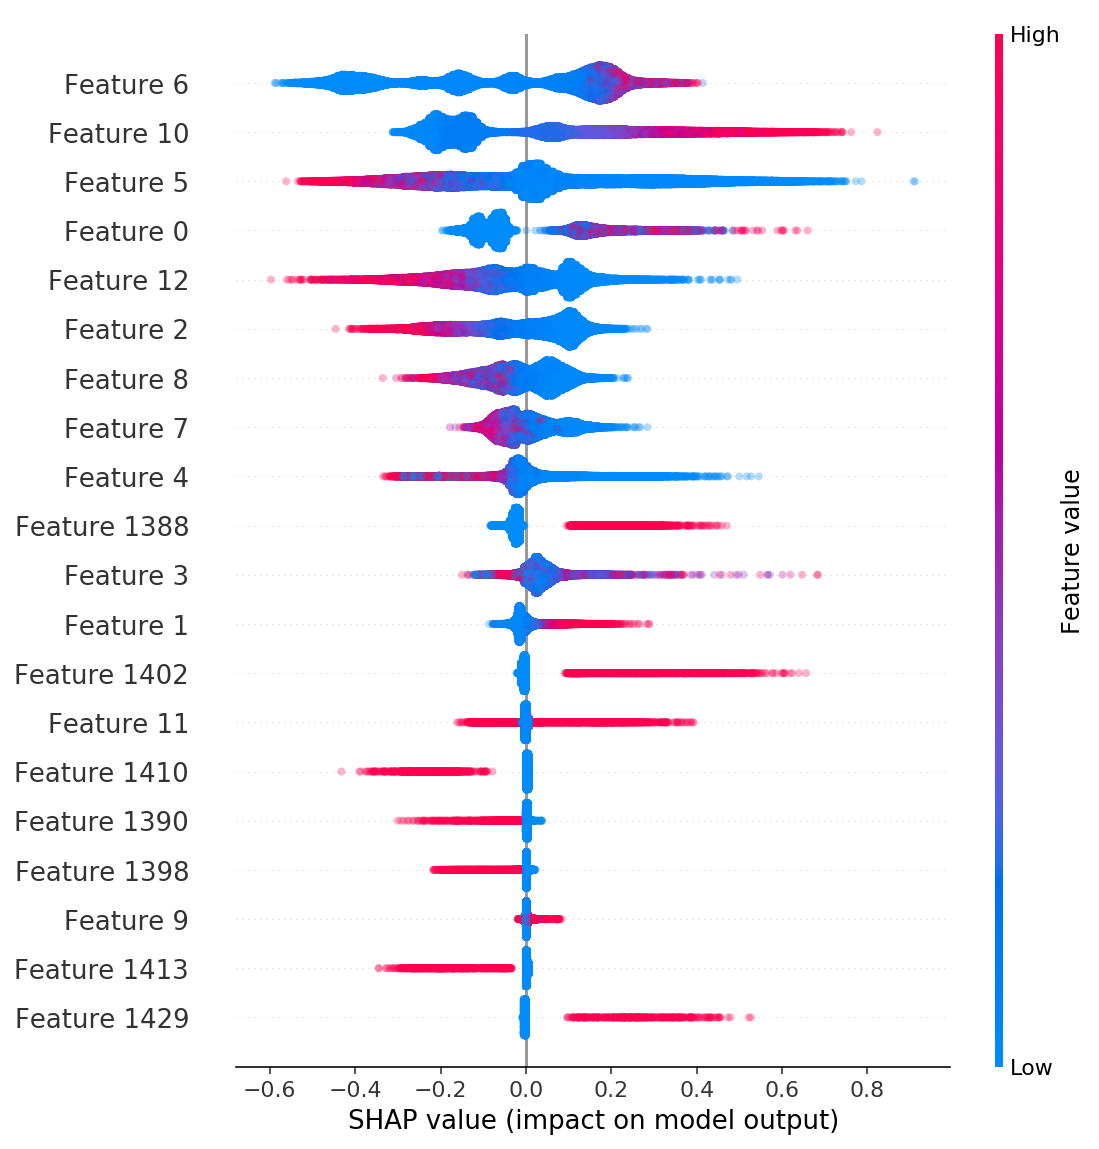

In [81]:
shap.summary_plot(shap_values, X_arr, max_display=20, alpha=0.3)

## [XGBoost features importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score)

In [82]:
def get_feature_score(booster, importance):
    gains_xgb = booster.get_score(importance_type=importance)
    gains = {}
    for f, g in gains_xgb.items():
        gains[f] = g
    sorted_gains = sorted(list(gains.items()), key=lambda x: -x[1])
    return sorted_gains


features_scores = get_feature_score(bst, 'gain')[:20]

In [83]:
f_names, f_scores = zip(*features_scores)
features_scores_pdf = pd.DataFrame({'feature': f_names, 'gain': f_scores})

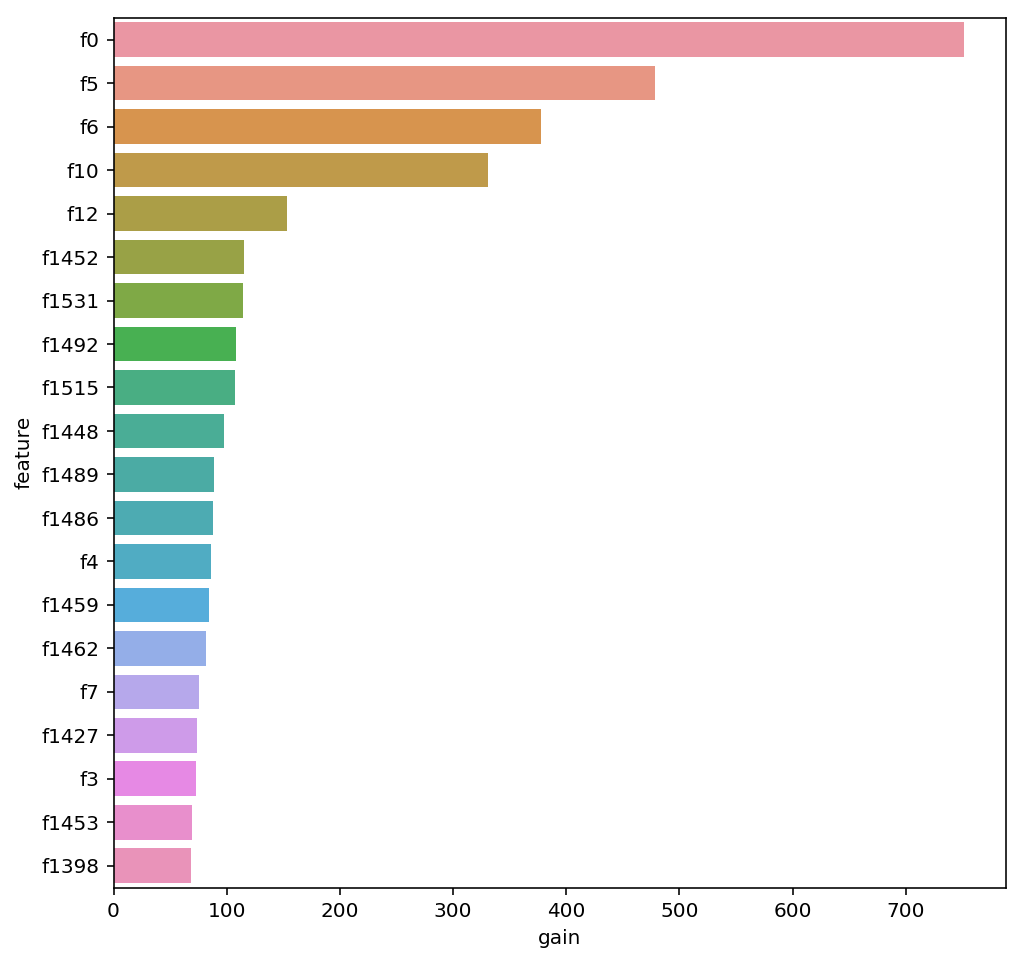

In [84]:
_, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x='gain', y='feature', data=features_scores_pdf)
plt.show()

# [Practical Lessons From Facebook](https://quinonero.net/Publications/predicting-clicks-facebook.pdf)

## Prepare Data

* Реализуйте модель из статьи (LogReg поверх XGBoost)

* Попробуйте реализовать Negatives Subsampling + Re-calibration описанный в статье (доп. баллы)

In [85]:
train_df, val_df, test_df = first_train_df, first_val_df, frist_test_df

In [101]:
%%time

from pyspark.mllib.linalg import Vectors

def df_to_csr(df, dim):
    data = []
    row_ind = []
    col_ind = []
    
    sparse_vecs = df.rdd.map(lambda row: row.features).collect()
    dim = len(sparse_vecs[0])
    print(dim)
    
    for i, vec in enumerate(sparse_vecs):
        for idx, val in enumerate(vec.values):
            data.append(val)
            row_ind.append(i)
            col_ind.append(idx)
    return csr_matrix((data, (row_ind, col_ind)), shape=(len(sparse_vecs), dim))

# Regressor for raw df
class Logistic_Regressor_over_XGBoost:
    def __init__(self):
        self.xgb_estimator = XGBoostEstimator(
            featuresCol="features", 
            labelCol="label", 
            predictionCol="prediction",
            colsample_bytree=0.9,
            eta=0.15,
            gamma=0.9,
            max_depth=8,
            min_child_weight=50.0,
            subsample=0.9,
            objective='binary:logistic',
            eval_metric='logloss', 
            silent=0,
            num_round=20,
            nthread=1,
            nworkers=1
        )
        self.num_columns = num_columns = ['_c{}'.format(i) for i in range(1, 14)]
        self.xgb_estimator_path = os.path.join(DATA_PATH, 'xgb_mean_target.model')
        self.pipeline_model = None
    
    def fit(self, train_df):
        cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]
        mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]

        assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")
        
        pipeline = Pipeline(stages=mean_target_encoders + [assembler])
        self.pipeline_model = pipeline.fit(train_df)
        
        print(self.__prepare_df(train_df).first())
        train_df = self.__prepare_df(train_df) \
            .select(F.col('_c0').alias('label'), 'features', 'id') \
            .cache()
        print(train_df.first())
        self.xgb_estimator = self.xgb_estimator.fit(train_df)
        self.__save_xgb_estimator(self.xgb_estimator)
        
        leaf_vectors = self.__to_leafs(train_df)
        
    
    def predict(self, df):
        df = self.__prepare_df(df).select('features', 'id')
        predictions = self.estimator.transform(df)
        
        return predictions
        
    def __save_xgb_estimator(self, estimator):
        path = self.xgb_estimator_path
        if os.path.exists(path):
            os.remove(path)
        estimator._call_java("booster").saveModel(path)
        
    def __to_leafs(self, df):
        booster = xgb.Booster()
        booster.load_model(self.xgb_estimator_path)
        dim = 40
        X = df_to_csr(df, dim)
        dmatrix = xgb.DMatrix(X)
        leaf_sets = booster.predict(dmatrix, pred_leaf=True)
        
        max_leaf = np.max(leaf_sets)
        def to_sparse_vector(leafs):
            leafs = np.unique(np.sort(leafs))
            return Vectors.sparse(max_leaf + 1, leafs, np.ones_like(leafs, dtype=np.double))
            
        sparse_vectors = [to_sparse_vector(leafs) for leafs in leaf_sets]
        return sparse_vectors[:5]
            
        
    def __prepare_df(self, df):
        assert self.pipeline_model is not None
        
        df = df.fillna(0, subset=self.num_columns) 
        return self.pipeline_model.transform(df)

CPU times: user 47 µs, sys: 2 µs, total: 49 µs
Wall time: 51.7 µs


In [102]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

sample_df = df.sample(0.01)

In [103]:
Logistic_Regressor_over_XGBoost().fit(sample_df)

Row(_c15='0aadb108', _c14='8cf07265', _c0=0, _c1=0, _c2=0, _c3=2, _c4=2, _c5=1272, _c6=16, _c7=1, _c8=14, _c9=14, _c10=0, _c11=1, _c12=0, _c13=2, _c16='c798ded6', _c17='91e6318a', _c18='25c83c98', _c19='fe6b92e5', _c20='83b2c64e', _c21='062b5529', _c22='a73ee510', _c23='3b08e48b', _c24='a907d01a', _c25='1b2022a0', _c26='1fdfd0bf', _c27='1adce6ef', _c28='2de5271c', _c29='b74e1eb0', _c30='d4bb7bd8', _c31='7ce63c71', _c32=None, _c33=None, _c34='af5dc647', _c35=None, _c36='dbb486d7', _c37='1793a828', _c38=None, _c39=None, id=8590314545, _c14_enc=0.2552165837037189, _c15_enc=0.1550368847502721, features=DenseVector([0.0, 0.0, 2.0, 2.0, 1272.0, 16.0, 1.0, 14.0, 14.0, 0.0, 1.0, 0.0, 2.0, 0.2552, 0.155]))
Row(label=0, features=SparseVector(15, {1: 51.0, 3: 9.0, 4: 4325.0, 7: 2.0, 8: 14.0, 12: 11.0, 13: 0.2609, 14: 0.3526}), id=1372)
[23:44:55] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
15


[SparseVector(199, {2: 1.0, 4: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 37: 1.0, 40: 1.0, 50: 1.0, 54: 1.0, 62: 1.0, 71: 1.0, 72: 1.0, 75: 1.0, 92: 1.0, 94: 1.0, 137: 1.0, 163: 1.0}),
 SparseVector(199, {26: 1.0, 50: 1.0, 52: 1.0, 58: 1.0, 74: 1.0, 79: 1.0, 98: 1.0, 99: 1.0, 106: 1.0, 108: 1.0, 109: 1.0, 110: 1.0, 113: 1.0, 120: 1.0, 131: 1.0, 139: 1.0, 154: 1.0}),
 SparseVector(199, {5: 1.0, 7: 1.0, 9: 1.0, 34: 1.0, 35: 1.0, 37: 1.0, 45: 1.0, 51: 1.0, 53: 1.0, 55: 1.0, 62: 1.0, 72: 1.0, 73: 1.0, 74: 1.0, 133: 1.0, 163: 1.0, 168: 1.0}),
 SparseVector(199, {2: 1.0, 4: 1.0, 19: 1.0, 20: 1.0, 22: 1.0, 31: 1.0, 32: 1.0, 37: 1.0, 40: 1.0, 49: 1.0, 54: 1.0, 57: 1.0, 58: 1.0, 66: 1.0, 72: 1.0, 90: 1.0, 92: 1.0, 159: 1.0}),
 SparseVector(199, {2: 1.0, 4: 1.0, 15: 1.0, 19: 1.0, 20: 1.0, 21: 1.0, 37: 1.0, 39: 1.0, 49: 1.0, 54: 1.0, 58: 1.0, 61: 1.0, 62: 1.0, 72: 1.0, 75: 1.0, 78: 1.0, 90: 1.0, 163: 1.0}),
 SparseVector(199, {50: 1.0, 52: 1.0, 56: 1.0, 66: 1.0, 71: 1.0, 87: 1.0, 95: 1.0, 106: 1.0, 108: 1.0, 112: 1.0, 128: 1.0, 130: 1.0, 134: 1.0, 135: 1.0, 142: 1.0, 143: 1.0, 149: 1.0, 154: 1.0, 167: 1.0}),
 SparseVector(199, {26: 1.0, 35: 1.0, 43: 1.0, 49: 1.0, 51: 1.0, 65: 1.0, 74: 1.0, 76: 1.0, 77: 1.0, 79: 1.0, 93: 1.0, 98: 1.0, 105: 1.0, 111: 1.0, 112: 1.0, 118: 1.0, 128: 1.0, 133: 1.0, 145: 1.0}),
 SparseVector(199, {16: 1.0, 20: 1.0, 30: 1.0, 31: 1.0, 32: 1.0, 33: 1.0, 43: 1.0, 52: 1.0, 62: 1.0, 70: 1.0, 73: 1.0, 80: 1.0, 108: 1.0, 121: 1.0, 130: 1.0, 133: 1.0, 144: 1.0, 146: 1.0}),
 SparseVector(199, {39: 1.0, 44: 1.0, 53: 1.0, 54: 1.0, 56: 1.0, 66: 1.0, 68: 1.0, 70: 1.0, 84: 1.0, 89: 1.0, 90: 1.0, 92: 1.0, 104: 1.0, 114: 1.0, 130: 1.0, 135: 1.0, 150: 1.0, 152: 1.0, 158: 1.0}),
 SparseVector(199, {43: 1.0, 48: 1.0, 51: 1.0, 70: 1.0, 73: 1.0, 79: 1.0, 95: 1.0, 98: 1.0, 106: 1.0, 107: 1.0, 108: 1.0, 113: 1.0, 133: 1.0, 138: 1.0, 143: 1.0, 147: 1.0, 159: 1.0, 161: 1.0}),
 SparseVector(199, {31: 1.0, 52: 1.0, 53: 1.0, 56: 1.0, 67: 1.0, 80: 1.0, 82: 1.0, 93: 1.0, 94: 1.0, 97: 1.0, 99: 1.0, 104: 1.0, 117: 1.0, 118: 1.0, 127: 1.0, 144: 1.0, 162: 1.0, 192: 1.0}),
 SparseVector(199, {10: 1.0, 32: 1.0, 45: 1.0, 52: 1.0, 56: 1.0, 71: 1.0, 75: 1.0, 87: 1.0, 88: 1.0, 100: 1.0, 101: 1.0, 103: 1.0, 104: 1.0, 126: 1.0, 127: 1.0, 136: 1.0, 142: 1.0, 143: 1.0, 144: 1.0, 150: 1.0}),
 SparseVector(199, {26: 1.0, 38: 1.0, 47: 1.0, 56: 1.0, 66: 1.0, 84: 1.0, 92: 1.0, 118: 1.0, 119: 1.0, 126: 1.0, 129: 1.0, 133: 1.0, 150: 1.0, 158: 1.0, 159: 1.0, 161: 1.0, 197: 1.0}),
 SparseVector(199, {2: 1.0, 4: 1.0, 14: 1.0, 18: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 24: 1.0, 54: 1.0, 57: 1.0, 58: 1.0, 62: 1.0, 66: 1.0, 73: 1.0, 77: 1.0, 78: 1.0, 111: 1.0, 117: 1.0}),
 SparseVector(199, {53: 1.0, 56: 1.0, 60: 1.0, 66: 1.0, 68: 1.0, 75: 1.0, 90: 1.0, 103: 1.0, 106: 1.0, 109: 1.0, 114: 1.0, 120: 1.0, 126: 1.0, 129: 1.0, 135: 1.0, 144: 1.0, 148: 1.0, 158: 1.0, 159: 1.0, 174: 1.0}),
 SparseVector(199, {2: 1.0, 4: 1.0, 12: 1.0, 22: 1.0, 38: 1.0, 42: 1.0, 62: 1.0, 68: 1.0, 79: 1.0, 98: 1.0, 106: 1.0, 110: 1.0, 114: 1.0, 119: 1.0, 120: 1.0, 123: 1.0, 142: 1.0}),
 SparseVector(199, {38: 1.0, 53: 1.0, 54: 1.0, 62: 1.0, 66: 1.0, 73: 1.0, 98: 1.0, 99: 1.0, 115: 1.0, 121: 1.0, 122: 1.0, 130: 1.0, 132: 1.0, 146: 1.0, 147: 1.0, 154: 1.0, 158: 1.0, 163: 1.0, 165: 1.0}),
 SparseVector(199, {19: 1.0, 22: 1.0, 34: 1.0, 37: 1.0, 39: 1.0, 43: 1.0, 45: 1.0, 61: 1.0, 64: 1.0, 68: 1.0, 75: 1.0, 83: 1.0, 87: 1.0, 99: 1.0, 101: 1.0, 104: 1.0, 109: 1.0, 113: 1.0, 116: 1.0, 149: 1.0}),
 SparseVector(199, {38: 1.0, 42: 1.0, 53: 1.0, 56: 1.0, 64: 1.0, 92: 1.0, 96: 1.0, 100: 1.0, 104: 1.0, 116: 1.0, 118: 1.0, 120: 1.0, 123: 1.0, 134: 1.0, 150: 1.0, 158: 1.0, 159: 1.0, 161: 1.0, 164: 1.0, 197: 1.0}),
 SparseVector(199, {22: 1.0, 34: 1.0, 36: 1.0, 52: 1.0, 56: 1.0, 60: 1.0, 70: 1.0, 75: 1.0, 87: 1.0, 98: 1.0, 104: 1.0, 106: 1.0, 110: 1.0, 125: 1.0, 130: 1.0, 138: 1.0, 142: 1.0, 143: 1.0, 154: 1.0}),
 SparseVector(199, {2: 1.0, 4: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 28: 1.0, 37: 1.0, 50: 1.0, 54: 1.0, 61: 1.0, 71: 1.

## Train

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

## Evaluation

In [ ]:
def calibration(model, df):
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    pass

Сравните новую модель со всеми предыдущими с помощью `get_ate`. При сравнении использовать еще и метрику calibration

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

### Make a Submission

Если в результате работы получилась модель, которая лучше чем ЛогРег из предыдущей практики, то точно нужно сделать submission.

In [ ]:
train_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

TEST_PATH  = os.path.join(DATA_PATH, 'test.csv')

test_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TEST_PATH)

In [ ]:
%%time

# Regressor for a raw df
class XGB_Regressor_MeanTarget:
    def __init__(self):
        self.estimator = XGBoostEstimator(
            featuresCol="features", 
            labelCol="label", 
            predictionCol="prediction",
            colsample_bytree=0.9,
            eta=0.15,
            gamma=0.9,
            max_depth=8,
            min_child_weight=50.0,
            subsample=0.9,
            objective='binary:logistic',
            eval_metric='logloss', 
            silent=0,
            num_round=20,
            nthread=1,
            nworkers=1
        )
        self.num_columns = ['_c{}'.format(i) for i in range(1, 14)]
        self.pipeline_model = None
    
    def fit(self, train_df):
        cat_columns = ['_c14', '_c15']
        cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]
        mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]
        print("mean target encoding ...")
        assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")
        
        pipeline = Pipeline(stages=mean_target_encoders + [assembler])
        self.pipeline_model = pipeline.fit(train_df)
        
        train_df = self.__prepare_df(train_df) \
            .select(F.col('_c0').alias('label'), 'features', 'id') \
            .cache()
        
        print("fitting xgboost ...")
        self.estimator = self.estimator.fit(train_df)
        
    def predict(self, df):
        df = self.__prepare_df(df).select('features', 'id')
        predictions = self.estimator.transform(df)
        
        return predictions
        
    def __prepare_df(self, df):
        assert self.pipeline_model is not None
        
        df = df.fillna(0, subset=self.num_columns) 
        return self.pipeline_model.transform(df)
        
        
regressor = XGB_Regressor_MeanTarget()
regressor.fit(train_df)

In [ ]:
test_predictions = regressor.predict(test_df)
test_predictions.first()

In [ ]:
get_second_element = F.udf(lambda v:float(v[1]),FloatType())

test_predictions \
    .withColumn('proba', get_second_element(F.col('probabilities'))) \
    .select('id', 'proba') \
    .first()

In [ ]:
submission_path = os.path.join(DATA_PATH, 'submition.csv')

In [ ]:
test_predictions \
    .withColumn('proba', get_second_element(F.col('probabilities'))) \
    .select('id', 'proba') \
    .toPandas() \
    .to_csv(submission_path, index=False)